In [1]:
from pyMuellerMat import common_mms as cmm
from pyMuellerMat import MuellerMat
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage.transform import rotate

from vampires_utils import *

from astropy.io import fits
import astropy.units as u
## These astropy things will be needed to calculate parallactic angle
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astroplan import Observer, FixedTarget

plt.style.use('dark_background')

#Some nicer printing options to avoid machine errors
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [2]:
## Various Rotational Offsets - Defaults are GPI values
hwp_offset = 0 #Degrees - Related to the definition of in the instrument Q frame - in the NIR this is very close to zero
sky_offset = 0 #Degrees - Related to how the parallactic angle maps onto the instrument Q frame
imrot_offset = 0 #Degrees - Related to how the image rotator angle maps to the instrument Q frame

In [3]:
wollaston_mm = cmm.WollastonPrism()
hwp_mm = cmm.Retarder() 
hwp_mm.properties['phi'] = 2*np.pi*0.5 #Make the HWP an ideal HWP
fast_hwp_mm = cmm.Retarder(name = "flc") 
fast_hwp_mm.properties['phi'] = 2*np.pi*0.5 #Make the fast switcher an ideal HWP
image_rotator = cmm.Retarder(name ="image_rotator")
image_rotator.properties['phi'] = 2*np.pi*0.5 #Image rotator is assumed to be ideal HWP for now. 
pupil_offset = cmm.Rotator(name="pupil_offset")
sky_mm = cmm.Rotator(name="sky_pa")
altitude_mm = cmm.Rotator(name="altitude")
m3_sign_flip = cmm.UV_Sign_Flip(name="M3")
#TODO: Include M3 sign-flip

In [4]:
sys_mm = MuellerMat.SystemMuellerMatrix([wollaston_mm,fast_hwp_mm,image_rotator,hwp_mm,altitude_mm,sky_mm])

In [5]:
filelist = sorted(glob.glob("/home/shared/Data/Subaru/Vampires/Reduced/20220127/mmb/HD29835/675/*.fits"))
print("Found {} files".format(len(filelist)))

Found 64 files


In [6]:
npix = 256 #Hard code this here to set the size of the imaging arrays

# A bunch of empty ararys - with descriptions of what they will be. 
pas = np.zeros(len(filelist)) #The parallactic angles (with the offset correction)
fast_hwps = np.zeros(len(filelist)) #The state of the fast switcher
camera = np.zeros(len(filelist))
imrot_angle = np.zeros(len(filelist))
hwps = np.zeros(len(filelist)) #The HWPs (with the offset correction)
data = np.zeros([len(filelist),npix,npix]) #All the podc slices
altitudes = np.zeros(len(filelist)) #Telescope altitudes in degrees
measurement_matrix = np.zeros([len(filelist),4]) #The measurement matrix
stokes_cube = np.zeros([4,npix,npix]) #The Stokes cube determined through an interative solver with a loss function
stokes_cube_lstsq = np.zeros([4,npix,npix]) #The Stokes cube
rotation_angle = np.zeros(len(filelist))

In [7]:
#Set the observing site 
subaru = Observer.at_site('subaru')

#Read in the files and fill up the arrays
for i,filename in enumerate(filelist):
    with fits.open(filename) as hdu:

        #Gather a bunch of info to calculate the parallactic angle using astroplan
        mjd = hdu[0].header["MJD"]
        t = Time(mjd,format='mjd')
        ra = hdu[0].header['RA']
        dec = hdu[0].header['DEC']
        coordinates = SkyCoord(ra, dec, frame='icrs',unit=(u.hourangle, u.deg))
        target = FixedTarget(coord=coordinates)
        pa = subaru.parallactic_angle(t,target)
        pas[i] = pa.to(u.deg).value 
        
        
        #Read in the other header info
        hwps[i] = (hdu[0].header['U_HWPANG'])-(hwp_offset) #Applying the offset and sign convention like in the GPI DRP
        imrot_angle[i] = hdu[0].header['D_IMRANG']
        fast_hwps[i] = hdu[0].header['U_FLCSTT']
        camera[i] = hdu[0].header['U_CAMERA']
        altitudes[i] = hdu[0].header['ALTITUDE']
        rotation_angle[i] = hdu[0].header['D_IMRPAD']

        data[i,:,:] = np.mean(hdu[0].data,axis=0) # Just use the mean-collapsed data
        
        # Now read in the data - We're going to take the mean of each data file here. 
        # We're also going to flip camera 2's y axis b/c we need to. 
        if camera[i] == 1:
            data[i,:,:] = np.flip(np.mean(hdu[0].data,axis=0),axis=-2) # Just use the mean-collapsed data
        else: 
            data[i,:,:] = np.mean(hdu[0].data,axis=0)#[::-1,:] # Just use the mean-collapsed data


In [8]:
rotation_angle

array([  -6.914,   -6.914,   -6.914,   -6.914,   -8.22 ,   -8.22 ,
         -8.22 ,   -8.22 ,   -9.047,   -9.047,   -9.047,   -9.047,
         -9.885,   -9.885,   -9.885,   -9.885,  -10.792,  -10.792,
        -10.792,  -10.792,  -11.629,  -11.629,  -11.629,  -11.629,
        -12.477,  -12.477,  -12.477,  -12.477,  -13.395,  -13.395,
        -13.395,  -13.395, -136.358, -136.358, -136.358, -136.358,
       -136.418, -136.418, -136.418, -136.418, -136.464, -136.464,
       -136.464, -136.464, -136.513, -136.513, -136.513, -136.513,
       -136.562, -136.562, -136.562, -136.562, -136.608, -136.608,
       -136.608, -136.608, -136.654, -136.654, -136.654, -136.654,
       -136.703, -136.703, -136.703, -136.703])

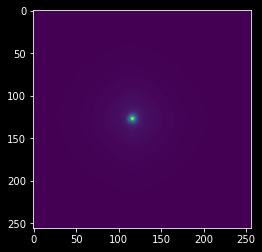

In [9]:
data = shift_data_stack(data,data[0])
plt.imshow(np.mean(data,axis=0))

In [10]:
for i, filename in enumerate(filelist):
    if camera[i] == 1:
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'o'
    else: 
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'e'
    
    if fast_hwps[i] == 1:
        sys_mm.master_property_dict['flc']['theta'] = 0
    else: 
        sys_mm.master_property_dict['flc']['theta'] = 45

    sys_mm.master_property_dict['Retarder']['theta'] = hwps[i]
    sys_mm.master_property_dict['sky_pa']['pa'] = pas[i]
    sys_mm.master_property_dict['image_rotator']['theta'] = imrot_angle[i]
    sys_mm.master_property_dict['altitude']['pa'] = altitudes[i]
    measurement_matrix[i] = sys_mm.evaluate()[0]

In [11]:
for i in np.arange(0,256):
    for j in np.arange(0,256):

        # this_pixel = data[:,i,j]
        this_pixel = data[:,i,j]
        if any(np.isnan(data[:,i,j])):
            stokes_cube[:,i,j] = np.nan
        else:
            #This version just does the simple linear inversion and is most similar to the GPI pipeline
            stokes_cube_lstsq[:,i,j] = np.linalg.lstsq(measurement_matrix,this_pixel)[0]
            

/tmp/ipykernel_240118/2171607332.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  stokes_cube_lstsq[:,i,j] = np.linalg.lstsq(measurement_matrix,this_pixel)[0]


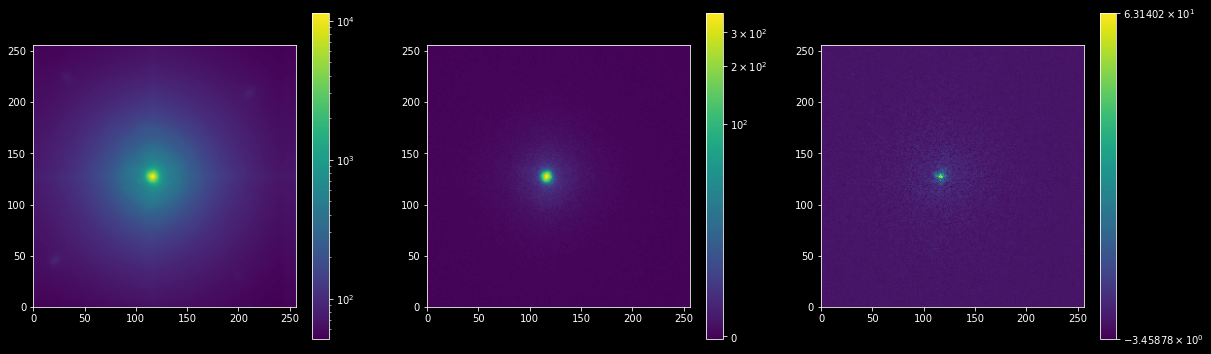

In [14]:
from matplotlib.colors import LogNorm, SymLogNorm
fig,axes = plt.subplots(1,3,figsize=(20,6))
axes = axes.flatten()
im0 = axes[0].imshow(stokes_cube_lstsq[0],norm=LogNorm())
im1 = axes[1].imshow(stokes_cube_lstsq[1],norm=SymLogNorm(linthresh=100))

# im0 = axes[0].imshow(stokes_cube_lstsq[0])
# im1 = axes[1].imshow(stokes_cube_lstsq[1])

im2 = axes[2].imshow(stokes_cube_lstsq[2],norm=SymLogNorm(linthresh=100))


low = 80
high = 180

low = 0
high = 256


axes[0].set_xlim(low,high)
axes[0].set_ylim(low,high)
axes[1].set_xlim(low,high)
axes[1].set_ylim(low,high)
axes[2].set_xlim(low,high)
axes[2].set_ylim(low,high)
plt.colorbar(im0,ax=axes[0])
plt.colorbar(im1,ax=axes[1])
plt.colorbar(im2,ax=axes[2])

In [16]:
total_I = np.sum(stokes_cube_lstsq[0])
q = np.sum(stokes_cube_lstsq[1])/total_I
u = np.sum(stokes_cube_lstsq[2])/total_I

In [18]:
print(q)
print(u)
print(np.sqrt(q**2+u**2))
print(np.degrees(0.5*np.arctan2(u,q)))

0.018903760746265864
0.005369769215319284
0.01965163076637287
7.928817410922477
